In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
print("Quant environment ready")


Quant environment ready


In [2]:
tickers = ["SPY","TLT","GLD"]
prices=yf.download(tickers, start="2015-01-01", auto_adjust=True)["Close"]
prices.head()

[*********************100%***********************]  3 of 3 completed


Ticker,GLD,SPY,TLT
Date,,,
2015-01-02,114.080002,170.589600,94.760414
2015-01-05,115.800003,167.508789,96.248978
2015-01-06,117.120003,165.931061,97.983139
2015-01-07,116.430000,167.998779,97.789665
2015-01-08,115.940002,170.979935,96.494568


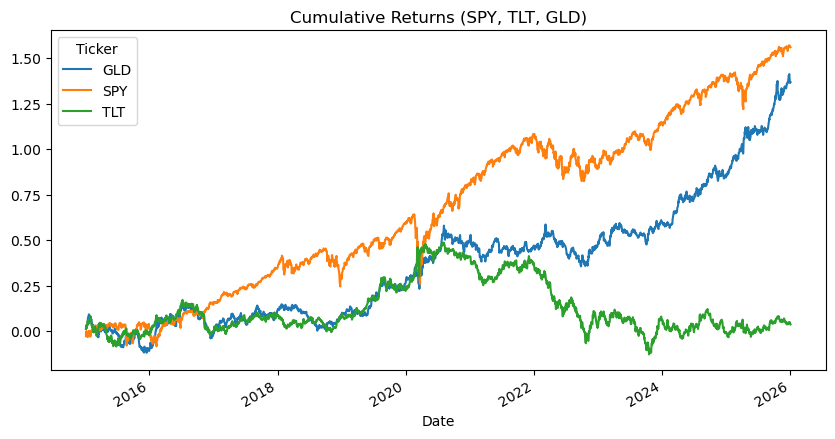

In [3]:
returns = prices.pct_change().dropna()
returns.cumsum().plot(figsize=(10,5), title="Cumulative Returns (SPY, TLT, GLD)")
plt.show()


In [4]:
# 1) Rolling volatility of SPY (annualized)
spy_vol = returns["SPY"].rolling(63).std() * np.sqrt(252)   # ~3 months window

# 2) Create regimes using quantiles (simple + effective)
q1, q2 = spy_vol.quantile([0.33, 0.66])

regime = pd.Series(index=spy_vol.index, dtype="object")
regime[spy_vol <= q1] = "Low Vol"
regime[(spy_vol > q1) & (spy_vol <= q2)] = "Medium Vol"
regime[spy_vol > q2] = "High Vol"

regime.value_counts(dropna=False), (q1, q2)

(High Vol      920
 Medium Vol    892
 Low Vol       892
 NaN            62
 Name: count, dtype: int64,
 (0.11185681717977823, 0.15912285986724276))

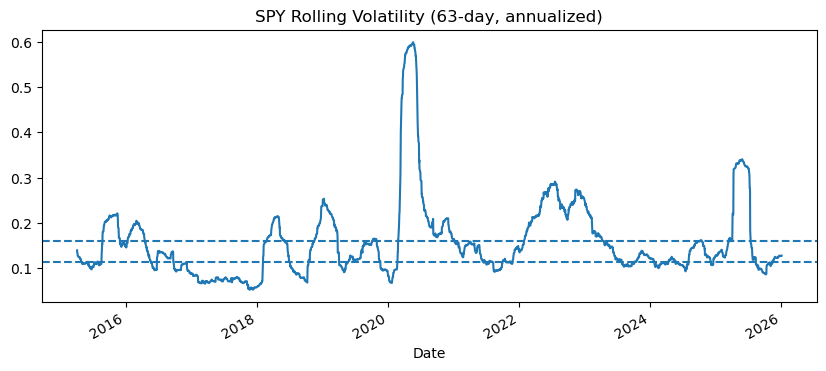

In [5]:
spy_vol.plot(figsize=(10,4), title="SPY Rolling Volatility (63-day, annualized)")
plt.axhline(q1, linestyle="--")
plt.axhline(q2, linestyle="--")
plt.show()


In [6]:
# Align regimes with returns and drop missing early window
df = returns.copy()
df["Regime"] = regime
df = df.dropna()

# Average daily return by regime
mean_by_regime = df.groupby("Regime")[["SPY","TLT","GLD"]].mean()

# Annualize (approx)
annualized_return = (1 + mean_by_regime)**252 - 1

annualized_return


Ticker,SPY,TLT,GLD
Regime,,,
High Vol,0.215409,-0.021797,0.159477
Low Vol,0.133203,-0.012806,0.109399
Medium Vol,0.118036,0.037092,0.134986


In [7]:
# Annualized volatility by regime
vol_by_regime = df.groupby("Regime")[["SPY","TLT","GLD"]].std() * np.sqrt(252)
vol_by_regime


Ticker,SPY,TLT,GLD
Regime,,,
High Vol,0.254347,0.178428,0.167917
Low Vol,0.095166,0.123355,0.128544
Medium Vol,0.145204,0.141731,0.141555
